<a href="https://colab.research.google.com/github/Jacofeldman/Metodos1_JacoboFeldman/blob/Complementaria/Complementaria_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Complementaria métodos computacionales 1
>
> Semana 05

***

# 1) Newton-Raphson con parada

### 1.a) 1.5pt

Escriba una función llamada `find_root_iters(f,x0,h=1e-6,max_iters=50,atol=1e-5,rtol=1e-5)` que implemente el método de Newton Rhapson, es decir, que dada una función $f$ y un valor inicial $x_0$, encuentre un valor `root` tal que $f(x)\approx 0$.

* Aproxime la derivada de la función usando la derivada central: $f'(x) = \frac{f(x+h)-f(x-h)}{2h}$.
* El método debe parar cuando alcance un número dado de iteraciones `max_iters`.
    * Si antes de alcanzar esas iteraciones se alcanza la precisión adecuada, es decir $f(x)\approx 0$, el método debe parar prematuramente y retornar el $x$ actual.
    * En python, ese $\approx$ significa usar `np.isclose(0.,f(x),atol,rtol)`. La tolerancia absoluta `atol` y la relativa `rtol` entran por parámetro, y pueden tener el valor por defecto de `1e-5`.
* Debe retornar el número de iteraciones y el valor de $x$.

Use el siguiente código para verificar su solución:
Puede usar el siguiente código para probar su función

```python
from scipy.special import lambertw
np.isclose(
    find_root_iters(lambda x: x*np.exp(x)-5,0.4)[1],
    lambertw(5)
)
```


In [34]:
import numpy as np

def find_root_iters(f, x0, h=1e-6, max_iters=50, atol=1e-5, rtol=1e-5):


    def derivative(f, x, h):

        return (f(x + h) - f(x - h)) / (2 * h)

    x = x0
    for n_iters in range(max_iters):
        f_x = f(x)
        df_x = derivative(f, x, h)

        if abs(df_x) < 1e-12:
            print("La derivada es muy pequeña, no se puede continuar.")
            return x, n_iters, False
        x_new = x - f_x / df_x
        if abs(x_new - x) < atol + rtol * abs(x):
            return x_new, n_iters + 1, True
        x = x_new


    return x, max_iters, False
print(find_root_iters(lambda x: x*np.exp(x)-5,0.4))

(1.326724665242204, 7, True)


### 1.b) 0.5pt

Haga una función llamada `find_root` que llame a la función anterior, con todos sus argumentos, pero que sólo retorne el valor de $x$, sin retornar el número de iteraciones. Esta función debe poder recibir arrays como argumento para `x0`.

Para ello, use `@np.vectorize` como decorador en `find_root`.

Pruebe su función con este código
```python
from scipy.special import lambertw
all(np.isclose(
    find_root(lambda x: x**3-0.4,[0.4,0.9j]),
    [0.7368+0.j, -0.36840314+0.63809297j]
))
```

In [7]:
import numpy as np



@np.vectorize
def find_root(f, x0, h=1e-6, max_iters=50, atol=1e-5, rtol=1e-5):


    root, _, _ = find_root_iters(f, x0, h, max_iters, atol, rtol)
    return root
test_result = find_root(lambda x: x**3-0.4,[0.4,0.9j])
print(test_result)

[ 0.7368063 +0.j         -0.36840315+0.63809297j]


### 1.c) Fractal de Newton 1.0 pt

Considerando la función $f(z) = z^3-(1+i)$, use el método de Newton Raphson para construir el fractal de Newton.

* Haga una grilla de valores iniciales complejos con parte real desde -2 hasta 2, y parte imaginaria desde -2i hasta 2i. Se recomienda usar `np.meshgrid`.
    * Haga un array de parte real `x` y parte imaginaria `y`, y con `x,y=np.meshgrid(x,y)`, puede armar la grilla compleja con `z=x+1j*y`.
    * Para hacer pruebas, use sólo 20 valores en cada array (`x` y `y`). Para el resultado final, 150 valores en cada array.

* Use la función del ejercicio anterior, `find_root`, para hallar las raíces cúbicas de (1+i) a las que converge cada condición inicial de la grilla.

* Use `np.angle` para hallar el ángulo de estas soluciones en los complejos. Grafique los valores de estos ángulos con `plt.imshow`.

Su imagen resultante se debe parecer a [esto](https://upload.wikimedia.org/wikipedia/commons/d/db/Julia_set_for_the_rational_function.png).

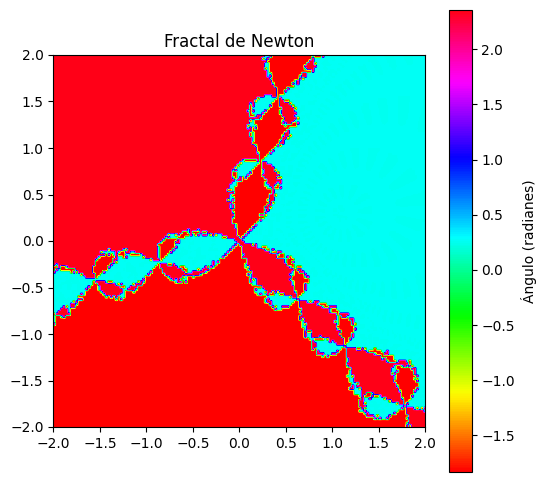

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def f(z):
    return z**3 - (1 + 1j)
def create_complex_grid(x_min, x_max, y_min, y_max, n_points):

    x = np.linspace(x_min, x_max, n_points)
    y = np.linspace(y_min, y_max, n_points)

    x, y = np.meshgrid(x, y)

    z = x + 1j * y
    return z



z_grid = create_complex_grid(-2, 2, -2, 2, 20)


roots = find_root(f, z_grid)

z_grid_fine = create_complex_grid(-2, 2, -2, 2, 150)
roots_fine = find_root(f, z_grid_fine)
angles_fine = np.angle(roots_fine)
angles = np.angle(roots)
plt.figure(figsize=(6, 6))
plt.imshow(angles_fine ,extent=(-2, 2, -2, 2), origin='lower', cmap='hsv')
plt.colorbar(label="Ángulo (radianes)")
plt.title("Fractal de Newton")
plt.show()



# 2) Interpolación de Lagrange con álgebra lineal

Dadas $n$ observaciones de datos $(x_0,y_0), (x_1,y_1), ... , (x_{n-1},y_{n-1})$, se quieren hallar $n$ coeficientes tales que para todo $k$,
$$
y_k = \sum_{i=0}^{n-1} a_i x_k^i
$$
Esto se puede representar matricialmente de esta manera:

$$
V \, \vec{a} = \vec{y}
$$

\begin{equation}
\begin{pmatrix}
x_0^{n-1} & ... & x_0^2 & x_0 & 1 \\
x_1^{n-1} & ... & x_0^2 & x_0 & 1 \\
... & ... & ... & ... \\
x_{n-1}^{n-1} & ... & x_{n-1}^2 & x_{n-1} & 1
\end{pmatrix}
\begin{pmatrix}
a_{n-1} \\
... \\
a_2 \\
a_1 \\
a_0
\end{pmatrix} = \begin{pmatrix}
y_0 \\
y_1 \\
... \\
y_{n-1}
\end{pmatrix}
\end{equation}

Esa matriz de arriba se conoce como la matriz de Vandermonde, y se puede generar con `np.vander`.

Los coeficientes de interpolación se obtienen como $\vec{a}=V^{-1}\vec{y}$. Use `np.linalg.inv` para invertir la matriz.

**2.0pt**

Encuentre de esta manera los coeficientes de interpolación $a_i$ para la función $f(x)=e^{-x^2}$, para los puntos `x = np.linspace(-5,5,n)`, para varios `n`, desde 5 hasta 11. Grafique para cada $n$ la función continua, los datos, y la función de interpolación (el polinomio con los coeficientes obtenidos) Responda: ¿Por qué la interpolación diverge entre punto y punto?

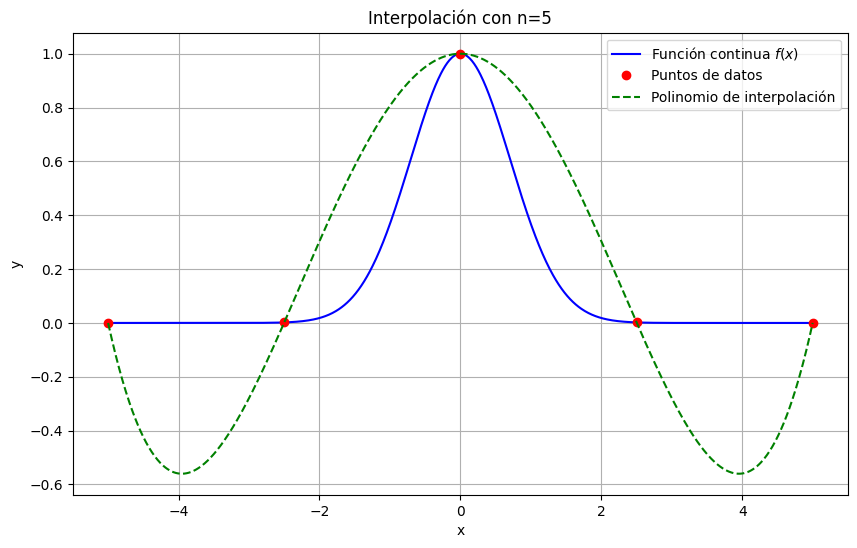

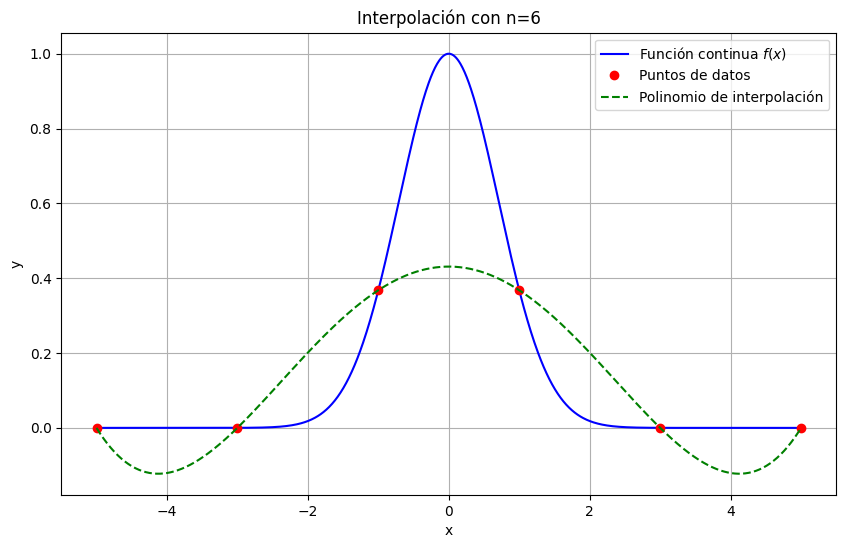

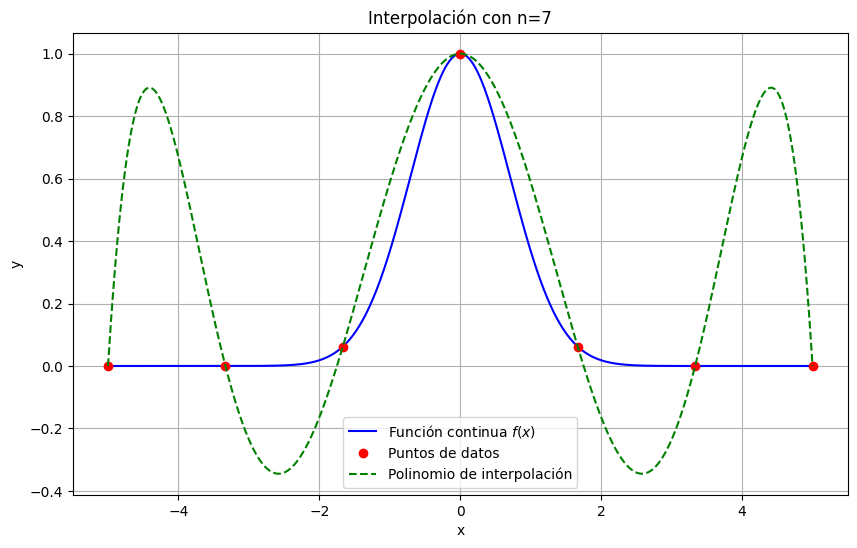

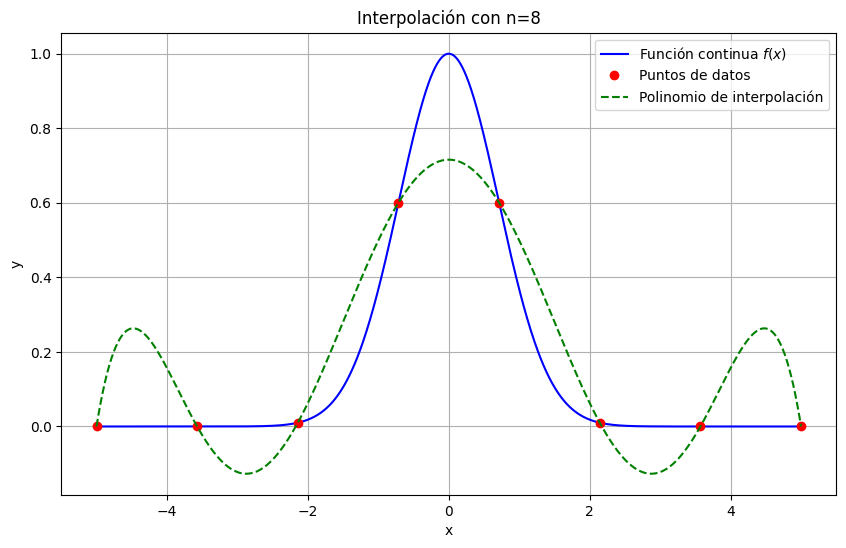

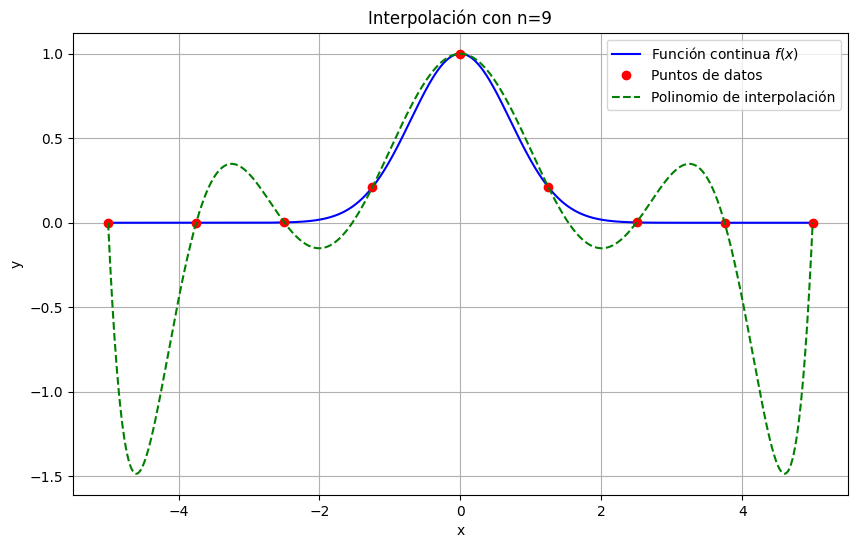

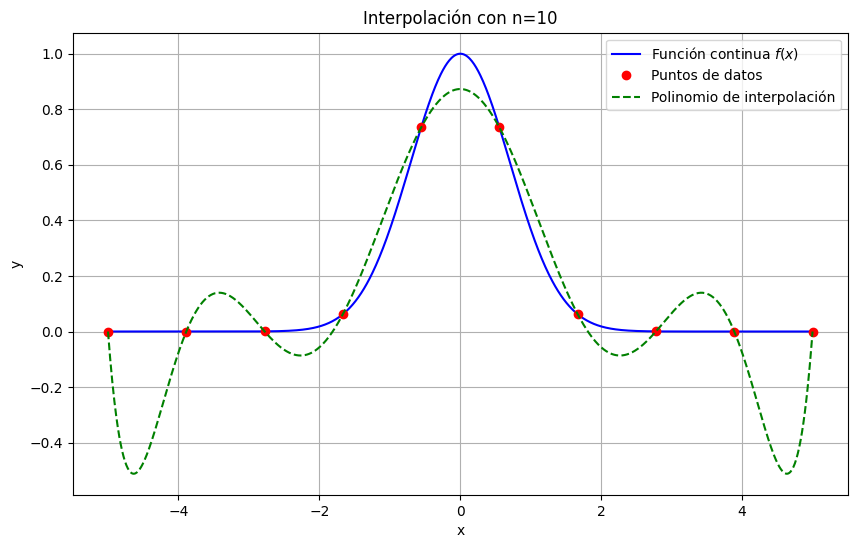

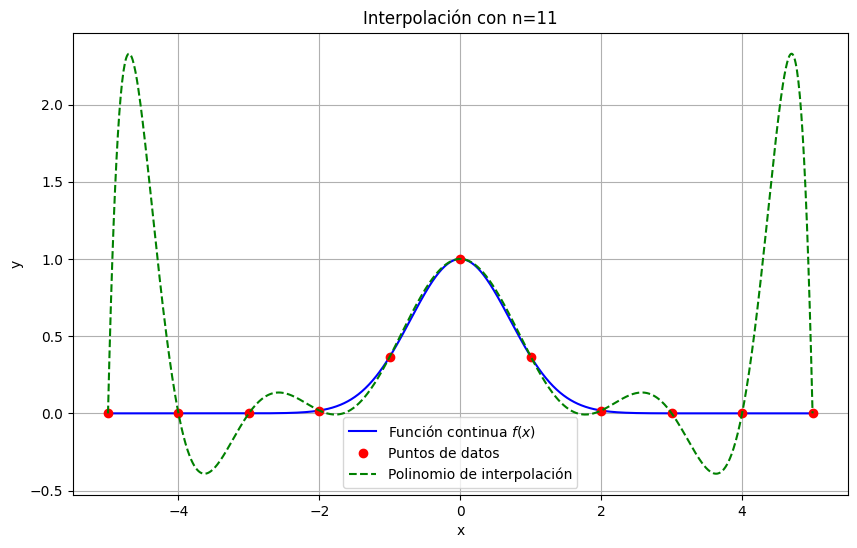

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):

    return np.exp(-x**2)

def vandermonde_matrix(x, n):

    return np.vander(x, n, increasing=True)

def interpolate_and_plot(n_values):

    x_fine = np.linspace(-5, 5, 1000)

    for n in n_values:

        x_data = np.linspace(-5, 5, n)
        y_data = f(x_data)


        V = vandermonde_matrix(x_data, n)


        V_inv = np.linalg.inv(V)
        coefficients = V_inv @ y_data


        V_fine = vandermonde_matrix(x_fine, n)
        y_interp = V_fine @ coefficients


        plt.figure(figsize=(10, 6))
        plt.plot(x_fine, f(x_fine), 'b-', label='Función continua $f(x)$')
        plt.plot(x_data, y_data, 'ro', label='Puntos de datos')
        plt.plot(x_fine, y_interp, 'g--', label='Polinomio de interpolación')
        plt.title(f'Interpolación con n={n}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)
        plt.show()

n_values = range(5, 12)
interpolate_and_plot(n_values)

Los polinomios de alto grado pueden oscilar entre los puntos de datos y tambien que la matriz de vandermonde, a medida que "n" aumenta, se vuelve mal condicionada y cada vez representa con menos exactitud el polinomio deseado.